In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd workspace/theislab/mubind/notebooks/batch

/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/notebooks/batch


In [3]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0


In [4]:
import itertools

def _mismatch(word, letters, num_mismatches):
    for locs in itertools.combinations(range(len(word)), num_mismatches):
        this_word = [[char] for char in word]
        for loc in locs:
            orig_char = word[loc]
            this_word[loc] = [l for l in letters if l != orig_char]
        for poss in itertools.product(*this_word):
            yield "".join(poss)



In [5]:
# motif = "ATT"
# x2, y2 = mb.datasets.simulate_xy(motif, n_trials=2100, seqlen=len(motif) + 1, max_mismatches=min(len(motif), 2), counts_size=1)
# x2, y2
# df = pd.DataFrame(data=y2)
# df.columns = [1]
# df.index = x2
# df[0] = 0
# df = df[[0, 1]]

In [27]:
df = mb.bindome.datasets.ProBound.ctcf(flank_length=0)
df = df.sort_values(1, ascending=False).reset_index(drop=True)
# data = df.head(1000)
# data = df.copy()
data = df.sample(10000, random_state=50)
# data = df.copy()
data.index = data['seq']

# remove as many nucleotides as posisble (faster training/convergence)
data.index = data.index.astype(str).str[45:]


# data.index = data.index.astype(str).str[-15:]
del data['seq']

In [28]:
data.shape

(10000, 2)

In [29]:
data = data.sample(data.shape[0], random_state=100)

In [30]:
# # define batches
# batch = np.random.randint(2, size=data.shape[0])

In [31]:
# # data[batch == 0] = data[batch == 0] + 20
# # data[batch == 1] = data[batch == 1] + 10
# data['batch'] = batch
#
# data = data[data['batch'] == 1]

In [32]:


from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 1

In [33]:
# TODO: skipped for now
n_rounds = 2

print('loading object (# entries)', data.shape[0])
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds, labels=[0, 1])
train = tdata.DataLoader(dataset=dataset,
                         # batch_size=256,
                         batch_size=512,
                         shuffle=False)

loading object (# entries) 10000


In [34]:
import warnings
warnings.filterwarnings('ignore')

In [35]:
import numpy as np

In [36]:
%load_ext line_profiler


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [37]:
# %lprun -f mb.tl.train_network mb.tl.train_network(model, train, device, next_optimiser, criterion, num_epochs=20, early_stopping=100, log_each=2, dirichlet_regularization=0, exp_max=40, verbose=0)

In [38]:
# %lprun -f mb.tl.train_iterative mb.tl.train_iterative(train, device, w=18, show_logo=False, opt_kernel_shift=0, opt_kernel_length=0, dirichlet_regularization=dirichlet_regularization, lr=[0.01, 0.01], weight_decay=[0.01, 0.001], ignore_kernel=ignore_kernel, num_epochs=2, early_stopping=100, use_dinuc=False, n_kernels=n_kernels, log_each=log_each, stop_at_kernel=None)

In [41]:
# assign batch and data type

# data['batch'] = 0
# data['is_count_data'] = 1
# n_batches=3

dirichlet_regularization = 0
# for dirichlet_regularization_log in range(-5, 3):

n_epochs = 500
log_each = 2
n_kernels = 5
w = 15 # min(len(motif), 6)
lr = [0.01] * n_kernels
wd = [0.01,] + [0.001] * (n_kernels - 1)
early_stopping = [5,] + [25] * (n_kernels - 1)
opt_kernel_shift = 1
opt_kernel_length = 1

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 1

import time
t0 = time.time()

criterion = mb.tl.PoissonLoss()

for ignore_kernel in [1]: # [0, 1]:
    print('\n\n##NEW JOB')
    print('ignore kernel', ignore_kernel)
    model_by_k, res_next = mb.tl.optimize_iterative(train, device, w=w, show_logo=0, criterion=criterion,
                                                 opt_kernel_shift=opt_kernel_shift, opt_kernel_length=opt_kernel_length,
                                                 dirichlet_regularization=dirichlet_regularization, # 10 ** dirichlet_regularization_log,
                                                 lr=wd, weight_decay=wd, ignore_kernel=ignore_kernel, use_mono=True,
                                                 num_epochs=n_epochs, early_stopping=early_stopping, use_dinuc=True, # optimiser=torch.optim.LBFGS,
                                                 n_kernels=n_kernels, log_each=log_each, stop_at_kernel=None) #  seed=seed) # seeds.index[0]) #
    print('##DONE....\n\n')



print('total time: %.3f s' % ((time.time() - t0)))
# res = []
# model_by_k = {}

model = model_by_k





##NEW JOB
ignore kernel 1
next w 15 <class 'int'>
# rounds {2}
# batches 1
# kernels 5
# initial w 15
# enr_series True

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel mono at 0 to 1
setting grad status of kernel dinuc at 0 to 0
setting grad status of kernel mono at 1 to 0
setting grad status of kernel dinuc at 1 to 0
setting grad status of kernel mono at 2 to 0
setting grad status of kernel dinuc at 2 to 0
setting grad status of kernel mono at 3 to 0
setting grad status of kernel dinuc at 3 to 0
setting grad status of kernel mono at 4 to 0
setting grad status of kernel dinuc at 4 to 0


kernels mask [0 1 1 1 1]
optimizing using <class 'torch.optim.adam.Adam'> and <class 'mubind.tl.loss.PoissonLoss'> n_epochs 500 early_stopping 5
lr= 0.01, weight_decay= 0.01, dir weight= 0
Epoch:  3, Loss: 0.843029 , best epoch: 1 secs per epoch: 0.767 s
Epoch:  5, Loss: 0.842981 , best epoch: 1 secs per epoch: 0.559 s
Epoch:  7, Loss: 0.842991 , bes

KeyboardInterrupt: 

### We can visualize the overall results obtained by the network, once the training is finished

In [ ]:
import mubind as mb

In [ ]:
model = model_by_k
mb.tl.scores(model, train)


In [ ]:
counts = mb.tl.predict(model, train)
counts

In [ ]:
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1')


In [ ]:
mb.pl.conv_mono(model)


In [2]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = '../../annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda:0


In [3]:
import itertools

def _mismatch(word, letters, num_mismatches):
    for locs in itertools.combinations(range(len(word)), num_mismatches):
        this_word = [[char] for char in word]
        for loc in locs:
            orig_char = word[loc]
            this_word[loc] = [l for l in letters if l != orig_char]
        for poss in itertools.product(*this_word):
            yield "".join(poss)



In [4]:
# motif = "ATT"
# x2, y2 = mb.datasets.simulate_xy(motif, n_trials=2100, seqlen=len(motif) + 1, max_mismatches=min(len(motif), 2), counts_size=1)
# x2, y2
# df = pd.DataFrame(data=y2)
# df.columns = [1]
# df.index = x2
# df[0] = 0
# df = df[[0, 1]]

In [180]:
df = mb.bindome.datasets.ProBound.ctcf(flank_length=0)
df = df.sort_values(1, ascending=False).reset_index(drop=True)
# data = df.head(1000)
# data = df.copy()
data = df.sample(10000, random_state=50)
# data = df.sample(df.shape[0], random_state=50)
# data = df.copy()
data.index = data['seq']

# remove as many nucleotides as posisble (faster training/convergence)
data.index = data.index.astype(str).str[45:]


# data.index = data.index.astype(str).str[-15:]
del data['seq']

In [181]:
data.shape

(10000, 2)

In [182]:
data = data.sample(data.shape[0], random_state=100)

In [183]:
data.shape[0]

10000

In [184]:
data.shape

(10000, 2)

In [185]:
# # define batches
# batch = np.random.randint(2, size=data.shape[0])

In [186]:
# # data[batch == 0] = data[batch == 0] + 20
# # data[batch == 1] = data[batch == 1] + 10
# data['batch'] = batch
#
# data = data[data['batch'] == 1]

In [187]:


from matplotlib import rcParams
rcParams['figure.figsize'] = 5, 1

In [188]:
# TODO: skipped for now
n_rounds = 2

print('loading object (# entries)', data.shape[0])
dataset = mb.datasets.SelexDataset(data, n_rounds=n_rounds, labels=[0, 1])
train = tdata.DataLoader(dataset=dataset,
                         # batch_size=256,
                         batch_size=512,
                         shuffle=False)

loading object (# entries) 10000


In [189]:
import warnings
warnings.filterwarnings('ignore')

In [190]:
import numpy as np

In [191]:
%load_ext line_profiler


The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [192]:
# %lprun -f mb.tl.train_network mb.tl.train_network(model, train, device, next_optimiser, criterion, num_epochs=20, early_stopping=100, log_each=2, dirichlet_regularization=0, exp_max=40, verbose=0)

In [193]:
# %lprun -f mb.tl.train_iterative mb.tl.train_iterative(train, device, w=18, show_logo=False, opt_kernel_shift=0, opt_kernel_length=0, dirichlet_regularization=dirichlet_regularization, lr=[0.01, 0.01], weight_decay=[0.01, 0.001], ignore_kernel=ignore_kernel, num_epochs=2, early_stopping=100, use_dinuc=False, n_kernels=n_kernels, log_each=log_each, stop_at_kernel=None)

In [207]:
# assign batch and data type

# data['batch'] = 0
# data['is_count_data'] = 1
# n_batches=3

dirichlet_regularization = 0
# for dirichlet_regularization_log in range(-5, 3):

n_epochs = 100
log_each = 10
n_kernels = 4
lr = [0.01] * n_kernels
wd = [0.01,] + [0.001] * (n_kernels - 1)
early_stopping = [5,] + [25] * (n_kernels - 1)
w = 15 # min(len(motif), 6)
opt_kernel_shift = 1
opt_kernel_length = 1

from matplotlib import rcParams
rcParams['figure.figsize'] = 8, 1

import time
t0 = time.time()

criterion = mb.tl.PoissonLoss()

for ignore_kernel in [1]: # [0, 1]:
    print('\n\n##NEW JOB')
    print('ignore kernel', ignore_kernel)
    model_by_k, res_next = mb.tl.optimize_iterative(train, device, w=w, show_logo=0, criterion=criterion,
                                                 opt_kernel_shift=opt_kernel_shift, opt_kernel_length=opt_kernel_length,
                                                 dirichlet_regularization=dirichlet_regularization, # 10 ** dirichlet_regularization_log,
                                                 lr=wd, weight_decay=wd, ignore_kernel=ignore_kernel, use_mono=True,
                                                 num_epochs=n_epochs, early_stopping=early_stopping, use_dinuc=True, # optimiser=torch.optim.LBFGS,
                                                 n_kernels=n_kernels, log_each=log_each, stop_at_kernel=None) #  seed=seed) # seeds.index[0]) #
    print('##DONE....\n\n')


print('total time: %.3f s' % ((time.time() - t0)))
# res = []
# model_by_k = {}

model = model_by_k





##NEW JOB
ignore kernel 1
next w 15 <class 'int'>
# rounds {2}
# batches 1
# kernels 4
# initial w 15
# enr_series True

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel mono at 0 to 1
setting grad status of kernel dinuc at 0 to 0
setting grad status of kernel mono at 1 to 0
setting grad status of kernel dinuc at 1 to 0
setting grad status of kernel mono at 2 to 0
setting grad status of kernel dinuc at 2 to 0
setting grad status of kernel mono at 3 to 0
setting grad status of kernel dinuc at 3 to 0


kernels mask [0 1 1 1]
optimizing using <class 'torch.optim.adam.Adam'> and <class 'mubind.tl.loss.PoissonLoss'> n_epochs 100 early_stopping 5
lr= 0.01, weight_decay= 0.01, dir weight= 0
Epoch: 11, Loss: 0.876603 , best epoch: 9 secs per epoch: 0.309 s
Epoch: 21, Loss: 0.846500 , best epoch: 19 secs per epoch: 0.274 s
Epoch: 31, Loss: 0.846055 , best epoch: 29 secs per epoch: 0.254 s
Epoch: 41, Loss: 0.845735 , best epoch: 39 secs per epoc

### We can visualize the overall results obtained by the network, once the training is finished

In [208]:
import mubind as mb

In [209]:
model = model_by_k
mb.tl.scores(model, train)


{'r2_counts': 0.0633173031639348,
 'r2_foldchange': 0.019428439816456256,
 'r2_enr': -0.06102574844801589,
 'r2_fc': 0.020394325742846692,
 'pearson_foldchange': 0.1428087033161729}

In [210]:
counts = mb.tl.predict(model, train)
counts

,t0,t1,p0,p1,batch,n_rounds,enr_pred,enr_obs,f_pred,f_obs
AGTGGCTCTGCCACAGGCCTTTTTT,1.0,0.0,0.562498,0.437502,0,2,0.920002,0.5,-0.036211,-0.301030
GAGGTGAGTGCAGCATAAGTGTTGG,1.0,0.0,0.617354,0.382646,0,2,0.854882,0.5,-0.068094,-0.301030
TGTATATGTCTTCAAGGTAACAAAG,1.0,0.0,0.647491,0.352509,0,2,0.820950,0.5,-0.085683,-0.301030
CGATCCTCAGTATGCTTTTAGGCAA,1.0,0.0,0.633924,0.366076,0,2,0.836071,0.5,-0.077757,-0.301030
GGTTTAAACGCGAAGACCGGGCAGT,1.0,0.0,0.603675,0.396325,0,2,0.870703,0.5,-0.060130,-0.301030
...,...,...,...,...,...,...,...,...,...,...
TAGTGGTGAGGAGTACGTTTAACGG,0.0,1.0,0.607864,0.392136,0,2,0.865829,2.0,-0.062568,0.301030
GACGGTGGTGTCAGCATGGGCGATG,1.0,0.0,0.570468,0.429532,0,2,0.910259,0.5,-0.040835,-0.301030
TATATCCTACTGCAACGGCTCGTTT,0.0,2.0,1.233315,0.766685,0,2,0.791060,3.0,-0.101791,0.477121
ACCGTCTGTTATCCGCGCTCCTTCA,1.0,0.0,0.585021,0.414979,0,2,0.892719,0.5,-0.049285,-0.301030


In [211]:
rcParams['figure.figsize'] = 6, 6

In [212]:
train.dataset.rounds.shape

(10000, 2)

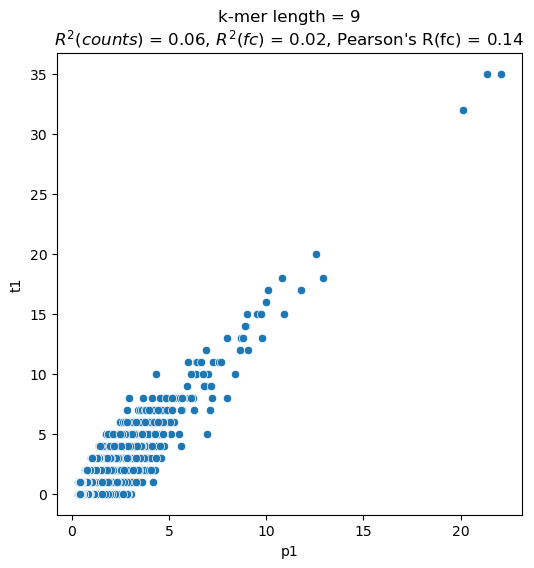

{'r2_counts': 0.0633173031639348,
 'r2_foldchange': 0.019428439816456256,
 'r2_enr': -0.06102574844801589,
 'r2_fc': 0.020394325742846692,
 'pearson_foldchange': 0.1428087033161729}

In [213]:
mb.pl.kmer_enrichment(model, train, log_scale=False, style='scatter', ylab='t1', xlab='p1', k=9)



#activities
[[[1.0000033  0.96222967]
  [1.0000024  0.7530154 ]
  [0.9999983  0.5838412 ]
  [1.0000737  0.38656613]]]

#log_etas
Parameter containing:
tensor([[ 2.2834, -2.2834]], device='cuda:0', requires_grad=True)
(4, 19)
<class 'int'>
[0, 5, 10, 15]
(4, 19)
<class 'int'>
[0, 5, 10, 15]
(4, 19)
<class 'int'>
[0, 5, 10, 15]


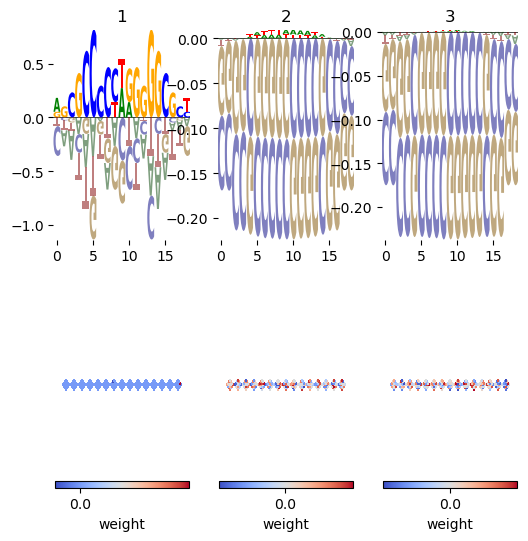

In [214]:
mb.pl.conv(model)
